# Pronóstico adaptativo

## Descripción del problema real

Los pronósticos de los precios de la electricidad en mercados liberalizados son un insumo fundamental para la toma de decisiones dentro de las organizaciones. Fundamentalmente, los pronosticos de corto plazo son utilizados en decisiones de carácter operativo. En el caso abordado, es necesario contar con los pronósticos para definir la politica de operación de una empresa del sector eléctrico.

## Descripción del problema en términos de los datos

La carpeta `datos/precios/` contiene los precios historicos horarios de la electricidad en la Bolsa de Energía del mercado eléctrico colombiano, publicados por el operador del mercado. Se desean obtener pronósticos para el precio promedio diario para los próximos siete (7) días a la fecha actual.

## Aproximaciones posibles

En este caso, se desea evaluar la capacidad de pronóstico de un ADALINE con aprendizaje en línea.

## Requerimientos

Usted debe:

* Procesar los datos históricos para conformar el conjunto de datos. Los archivos de Excel no pueden ser modificados y actualizados directamente por el operador del sistema. Su código debe leer los archivos y crear la serie de precios promedio diarios de la electricidad.


* Determinar si el modelo debe pronosticar los precios promedios sin ninguna transformación, o si la inclusión de una transformación (logaritmo natural, raíz cúbica, raíz cuadrada, etc) resulta en un incremento de la precisión del pronóstico.


* Generar el pronóstico para los precios de los próximos siete días.


* Preparar el código para que el modelo sea entrenado usando el gradiente y el momentum.


* Determinar cuál es el número óptimo de retardos (observaciones) que el modelo debe considerar hacia atrás para producir el pronóstico.


* Determinar los valores óptimos de la tasa de aprendizaje y el momentum.


## Solución

### Importar librerias

In [1]:
from IPython.display import display, HTML
from matplotlib.pyplot import figure

import matplotlib.pyplot as plt
import pandas as pd
import glob
import numpy as np
import tensorflow as tf
import numpy as np
import os
import scipy
import scipy.stats

from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from sklearn import metrics

from keras import optimizers
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout
from keras.models import Sequential
from keras.wrappers.scikit_learn import KerasRegressor
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard

tf.enable_eager_execution()
print(pd.__version__)

Using TensorFlow backend.


0.24.2


### Lectura de Datos

Se define la ruta de los archivos y los metodos que se usaran para la lectura de datos

In [2]:
data_path = "datos/precios/"
filenames = os.listdir(data_path)
filenames = [e for e in filenames if e[0] != '~']

print("Ruta: " + data_path + filenames[23])

Ruta: datos/precios/Precio_Bolsa_Nacional_($kwh)_2018.xls


Se leen los datos y se muestran algunos en una tabla para comprobar, pero se mantienen los errores en el dataset como espacion vacíos y NaN's, se elimina la columna de fecha

In [3]:
data = pd.read_excel(data_path + filenames[0], header=2, usecols="A:Y")

iterfiles = iter(filenames) 
next(iterfiles)

for f in iterfiles:
    data = data.append(pd.read_excel(data_path + f, header=2, usecols="A:Y"), sort=False, ignore_index=True)

# data = data.drop("Fecha", axis=1)
print("Numero de filas: " + str(len(data.index)))
data.tail()

Numero de filas: 8409


,Fecha,0,1,2,3,4,5,6,7,8,...,14,15,16,17,18,19,20,21,22,23
8404,2018-05-01,64.229226,64.229226,64.129226,64.129226,64.129226,64.129226,64.129226,64.229226,64.229226,...,71.229226,71.229226,69.229226,81.229226,86.229226,86.229226,86.229226,81.229226,71.229226,64.229226
8405,2018-05-02,63.332816,63.332816,63.332816,63.332816,63.332816,64.332816,67.832816,79.831816,80.832816,...,83.832816,83.832816,80.832816,80.832816,83.832816,83.832816,83.832816,80.832816,80.832816,67.832816
8406,2018-05-03,63.710848,64.210848,61.710848,61.710848,63.710848,64.210848,64.210848,67.710848,67.710848,...,79.710848,79.710848,79.710848,67.710848,79.710848,79.710848,79.710848,67.710848,67.710848,63.710848
8407,2018-05-04,61.543453,61.543453,61.543453,61.543453,61.543453,65.543453,61.543453,64.043453,65.543453,...,65.543453,65.543453,65.543453,65.543453,65.543453,72.543453,65.543453,65.543453,65.543453,64.043453
8408,2018-05-05,73.742918,73.742918,70.242918,70.242918,70.242918,70.242918,73.742918,73.742918,75.242918,...,73.742918,73.742918,75.242918,73.742918,75.242918,75.242918,75.242918,75.242918,75.242918,75.242918


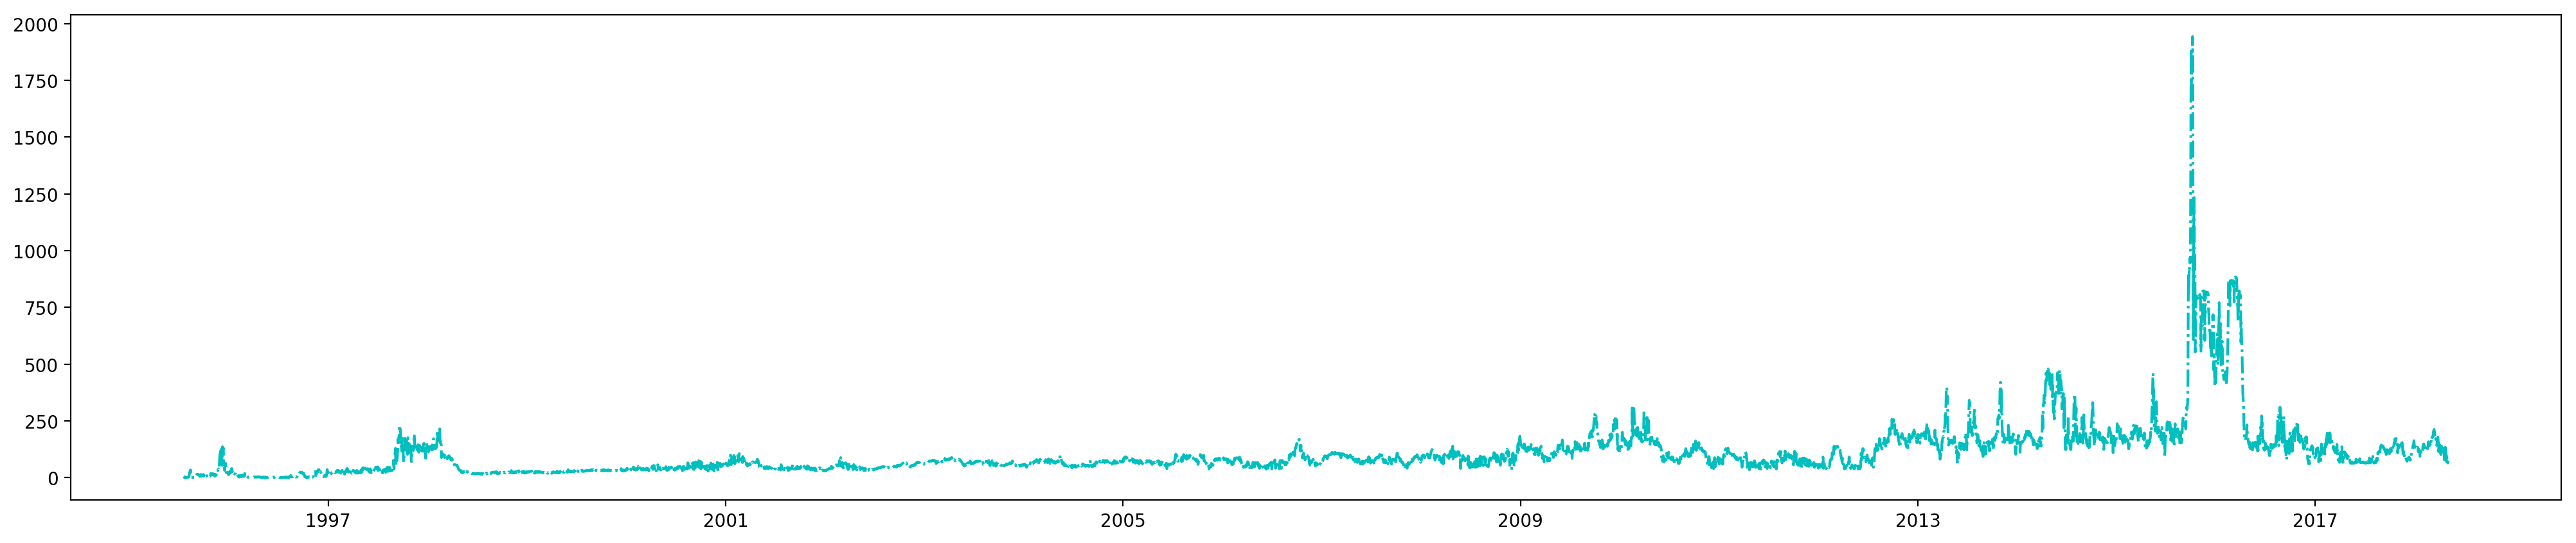

In [26]:
data["Fecha"] = pd.to_datetime(data["Fecha"])
data = data.sort_values(by=["Fecha"])
serie = pd.concat([data["Fecha"],data.mean(axis=1)],axis=1)

figure(num=None, figsize=(25,5), dpi=200, facecolor='w', edgecolor='k')
plt.plot(serie["Fecha"], serie.iloc[:,1],'c-.')
plt.show()

Luego se eliminan las filas en las que se presentan errores en los datos para limpiar el dataset y se vuelve a imprimir algunos datos para corroborar que se esta leyendo bien el archivo

In [5]:
nans = sum(pd.isnull(data).sum().values)
nans_per = 1 - (len(data.index) - nans) / len(data.index)

print(nans_per)

data.dropna(inplace=True)
data.reset_index(drop=True)

print("Numero de filas que quedan: " + str(len(data.index)))

data.tail()

0.029373290522059725
Numero de filas que quedan: 8381


,Fecha,0,1,2,3,4,5,6,7,8,...,14,15,16,17,18,19,20,21,22,23
8404,2018-05-01,64.229226,64.229226,64.129226,64.129226,64.129226,64.129226,64.129226,64.229226,64.229226,...,71.229226,71.229226,69.229226,81.229226,86.229226,86.229226,86.229226,81.229226,71.229226,64.229226
8405,2018-05-02,63.332816,63.332816,63.332816,63.332816,63.332816,64.332816,67.832816,79.831816,80.832816,...,83.832816,83.832816,80.832816,80.832816,83.832816,83.832816,83.832816,80.832816,80.832816,67.832816
8406,2018-05-03,63.710848,64.210848,61.710848,61.710848,63.710848,64.210848,64.210848,67.710848,67.710848,...,79.710848,79.710848,79.710848,67.710848,79.710848,79.710848,79.710848,67.710848,67.710848,63.710848
8407,2018-05-04,61.543453,61.543453,61.543453,61.543453,61.543453,65.543453,61.543453,64.043453,65.543453,...,65.543453,65.543453,65.543453,65.543453,65.543453,72.543453,65.543453,65.543453,65.543453,64.043453
8408,2018-05-05,73.742918,73.742918,70.242918,70.242918,70.242918,70.242918,73.742918,73.742918,75.242918,...,73.742918,73.742918,75.242918,73.742918,75.242918,75.242918,75.242918,75.242918,75.242918,75.242918


Cada fila es un dia, entonces se calcula una media de cada fila para determinar una media de precio diario para calcular lambda y el intervalo de confianza con el que se trabajará

In [27]:
mean_prices = data.sum(axis=1) / (len(data.columns))

xt, lamda, interval = scipy.stats.boxcox(mean_prices, alpha=0.05)
print("Lambda = {:g}".format(lamda))

print("Intervalo de confianza para Lambda = (" + str(round(interval[0], 5)) + ", " + str(round(interval[1], 5)) + ")")

Lambda = 0.202402
Intervalo de confianza para Lambda = (0.18908, 0.21578)


### Escalado de datos

In [28]:
serie = serie.dropna()

serie.isnull().sum()

Fecha    0
0        0
dtype: int64

In [29]:
serie = serie.reset_index(drop=True)

serie.columns = ["fecha","price"]

sc = MinMaxScaler(feature_range = (0, 1))

d = sc.fit_transform(serie["price"].values.reshape(-1,1)).reshape(-1,)

### Modelo ADALINE

In [30]:
dias_a_predecir = 24*7

In [31]:
class Model(object):
    def __init__(self, L):        
        # Inicio mi vector de pesos
        self.w = tf.contrib.eager.Variable([0.0] * (L))

    def __call__(self, x):
        # Añado bias a mi entrada y lo múltiplico por mis pesos para obtener el pronóstico
        x = tf.constant(np.array([1.0] + x, dtype=np.float32))
        y_pred = tf.reduce_sum(tf.multiply(self.w, x))
        return y_pred

    def fit(self, mu, x, y_desired):
        # multiplico por mis pesos
        y_pred = self(x)
        # saco mi error
        e = y_desired - y_pred
        # BIAS
        x = tf.constant(np.array([1.0] + x, dtype=np.float32))
        # gradient...
        self.w.assign_add(tf.scalar_mul(2 * mu * e, x))

#### Calibración del número de retardos adecuado

In [32]:
# Numero de retardos a probar
retardos = [2,3,4,5,6,7,8,10]

In [33]:
def tuning_retardos(retardos,d):
    
    resultado_retardos = []

    for i in range(len(retardos)):

        L = retardos[i]

        model = Model(L)

        y_pred = np.empty(len(d))
        y_pred[:] = np.nan

        for t in range(L, len(d)):
            x = d[t-L:t]
            y_pred[t] = model(x)
            model.fit(mu=0.05, x=x, y_desired=d[t])

        resultado_retardos.append([d[-(dias_a_predecir):],y_pred[-(dias_a_predecir):]])
        
    return resultado_retardos

resultado_retardos = tuning_retardos(retardos,d)

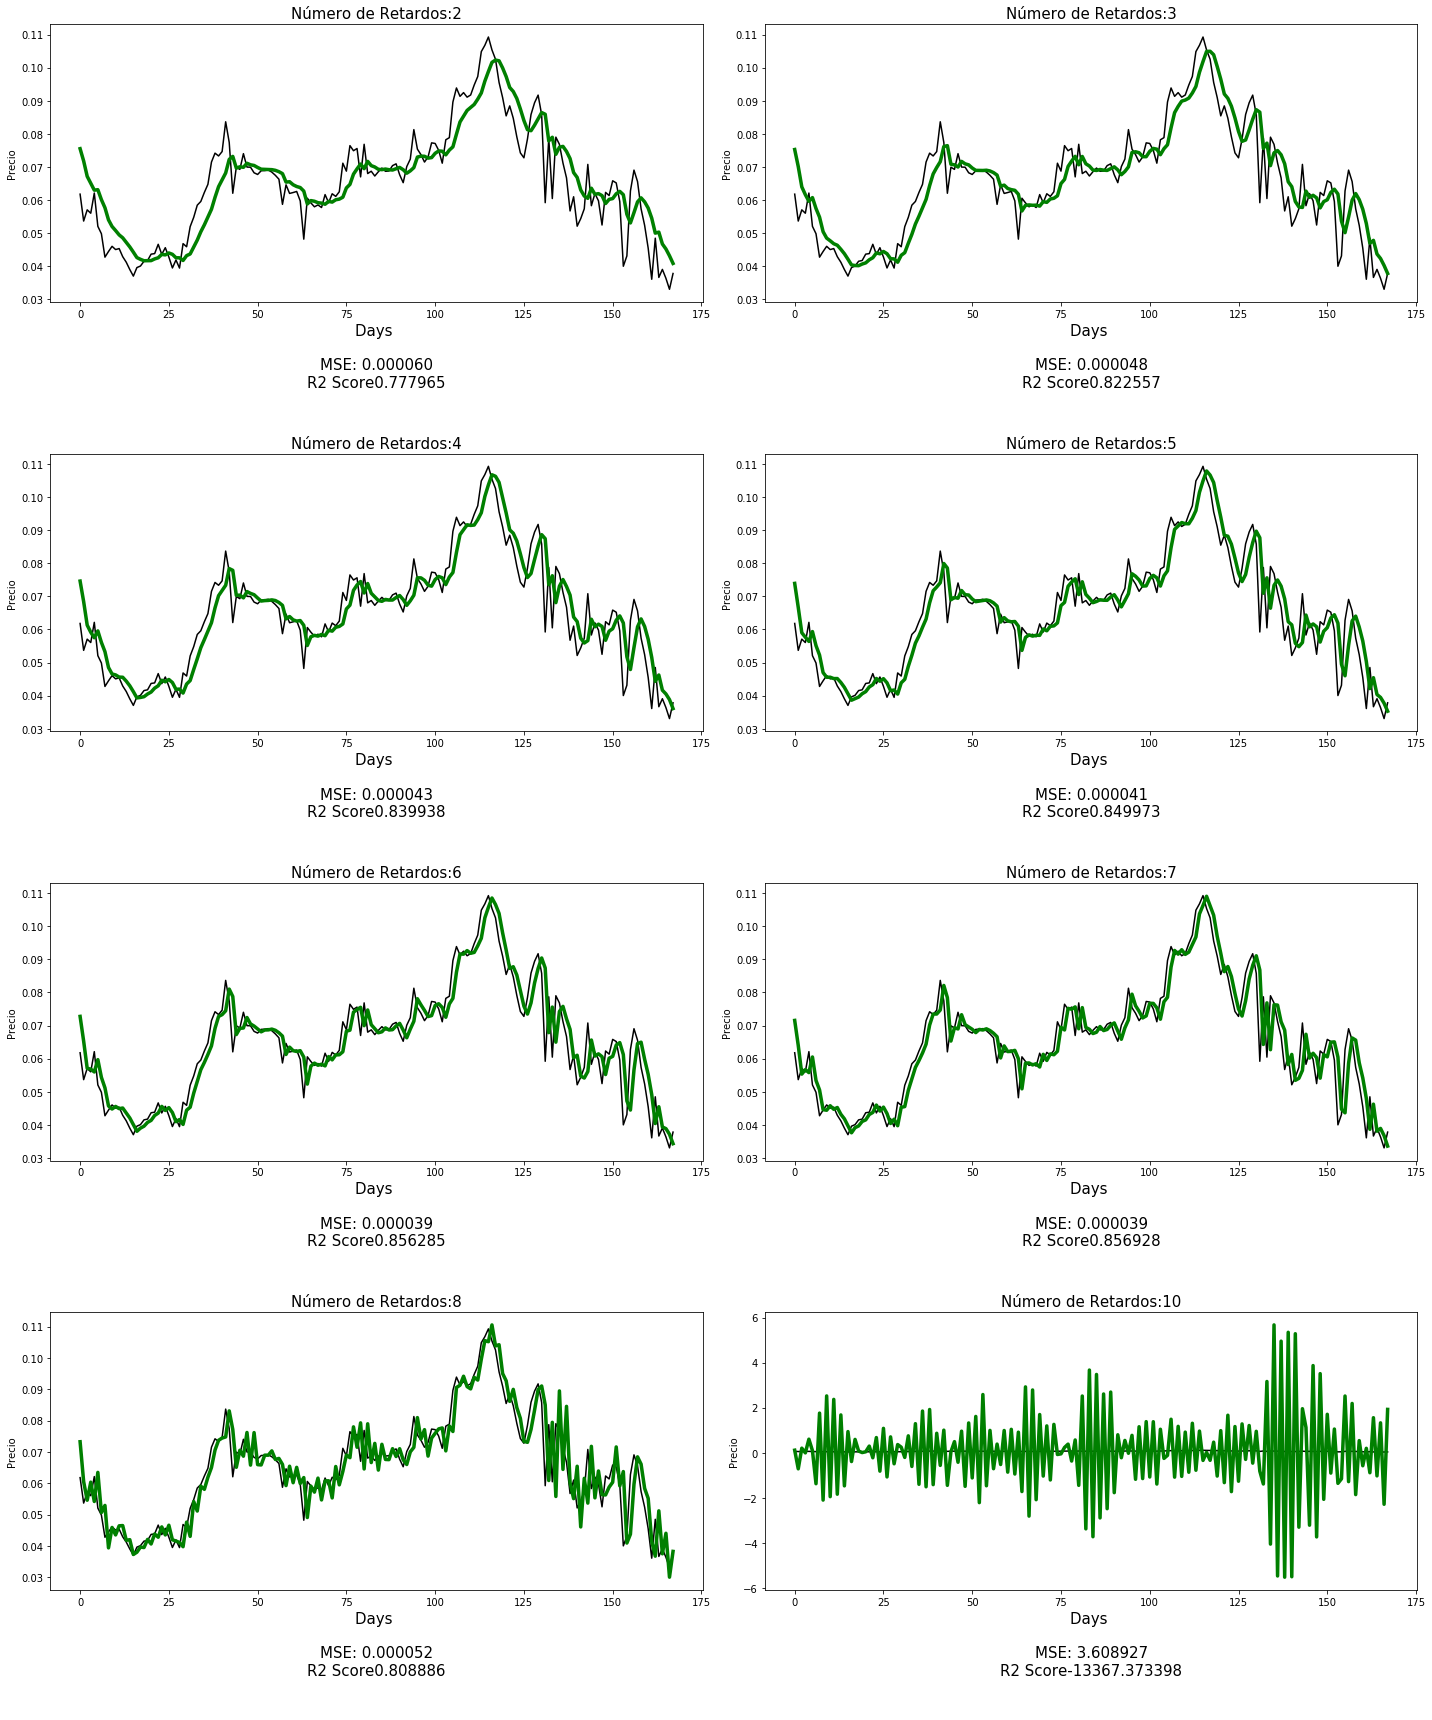

In [34]:
fig, axes = plt.subplots(nrows=4, ncols=2,figsize=(20,24))

count = 0
for fila in axes:
    for ax in fila:    
        titulo = str("Número de retardos:"+str(retardos[count])) 

        ax.plot(resultado_retardos[count][0],color = 'black',label = 'Real')
        ax.plot(resultado_retardos[count][1],color = 'green',label = 'Prediccion',linewidth=3.5)

        ax.set_xlabel('Days \n \n'+                     
                      str('MSE: ' + '{:f}'.format(metrics.mean_squared_error(resultado_retardos[count][0],resultado_retardos[count][1])))+'\n'+
                      str('R2 Score' + '{:f}'.format(r2_score(resultado_retardos[count][0],resultado_retardos[count][1]))+'\n \n'),fontsize=15) 

        ax.set_ylabel('Precio')
        ax.set_title(str('Número de Retardos:'+str(retardos[count])),fontsize=15)

        fig    
        plt.tight_layout()

        count+=1

#### Calibración de la tasa de aprendizaje

In [49]:
lr = [0.01, 0.001, 0.0001, 0.0001]

In [50]:
resultado_lr = []

for i in range(len(lr)):    
    L = 7

    model = Model(L)

    y_pred = np.empty(len(d))
    y_pred[:] = np.nan

    for t in range(L, len(d)):
        x = d[t-L:t]
        y_pred[t] = model(x)
        model.fit(mu=lr[i], x=x, y_desired=d[t])

    resultado_lr.append([d[-(dias_a_predecir):],y_pred[-(dias_a_predecir):]])

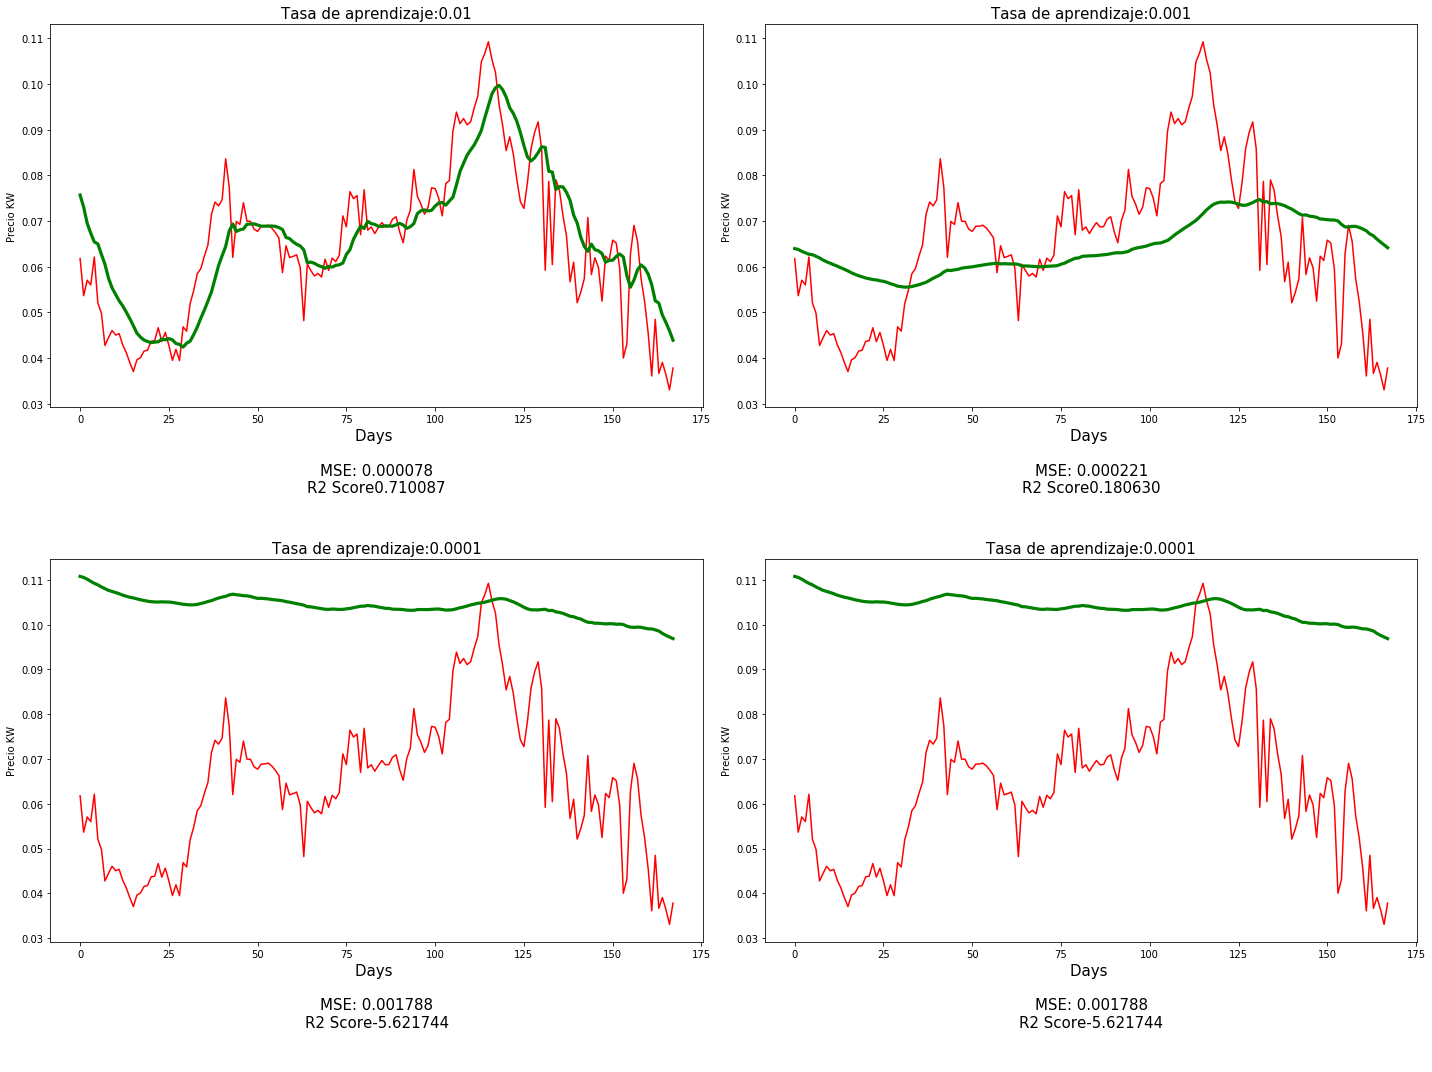

In [51]:
fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(20,15))

count = 0

for fila in axes:
    for ax in fila:
        #print(resultado_lr[count][1]) ##Error
        titulo = str("Número de retardos:"+str(retardos[count])) 

        ax.plot(resultado_lr[count][0],color = 'red',label = 'Real')
        ax.plot(resultado_lr[count][1],color = 'green',label = 'Prediccion',linewidth=3.2)

        ax.set_xlabel('Days \n \n'+                     
                      str('MSE: ' + '{:f}'.format(metrics.mean_squared_error(resultado_lr[count][0],resultado_lr[count][1])))+'\n'+
                      str('R2 Score' + '{:f}'.format(r2_score(resultado_lr[count][0],resultado_lr[count][1]))+'\n \n'),fontsize=15) 
                     
        ax.set_ylabel('Precio KW')
        ax.set_title(str('Tasa de aprendizaje:'+str(lr[count])),fontsize=15)

        fig    
        plt.tight_layout()

        count+=1


Al ejecutar un primer acercamiento al gradiente vemso qeu el mas acertado es 0.01, conociendo el rango adecuado se hace un grid nuevo con valores cercanos a 0.01 para obtener un valor mas preciso

In [52]:
lr = [0.007,0.008,0.009,0.01,0.02,0.03,0.04,0.05,0.06,0.07]

def tuning_lr(lr,d):
    
    resultado_lr = []

    for i in range(len(lr)):    
        L = 6

        model = Model(L)

        y_pred = np.empty(len(d))
        y_pred[:] = np.nan

        for t in range(L, len(d)):
            x = d[t-L:t]
            y_pred[t] = model(x)
            model.fit(mu=lr[i], x=x, y_desired=d[t])

        resultado_lr.append([d[-(dias_a_predecir):],y_pred[-(dias_a_predecir):]])
        
    return resultado_lr

resultado_lr = tuning_lr(lr,d)

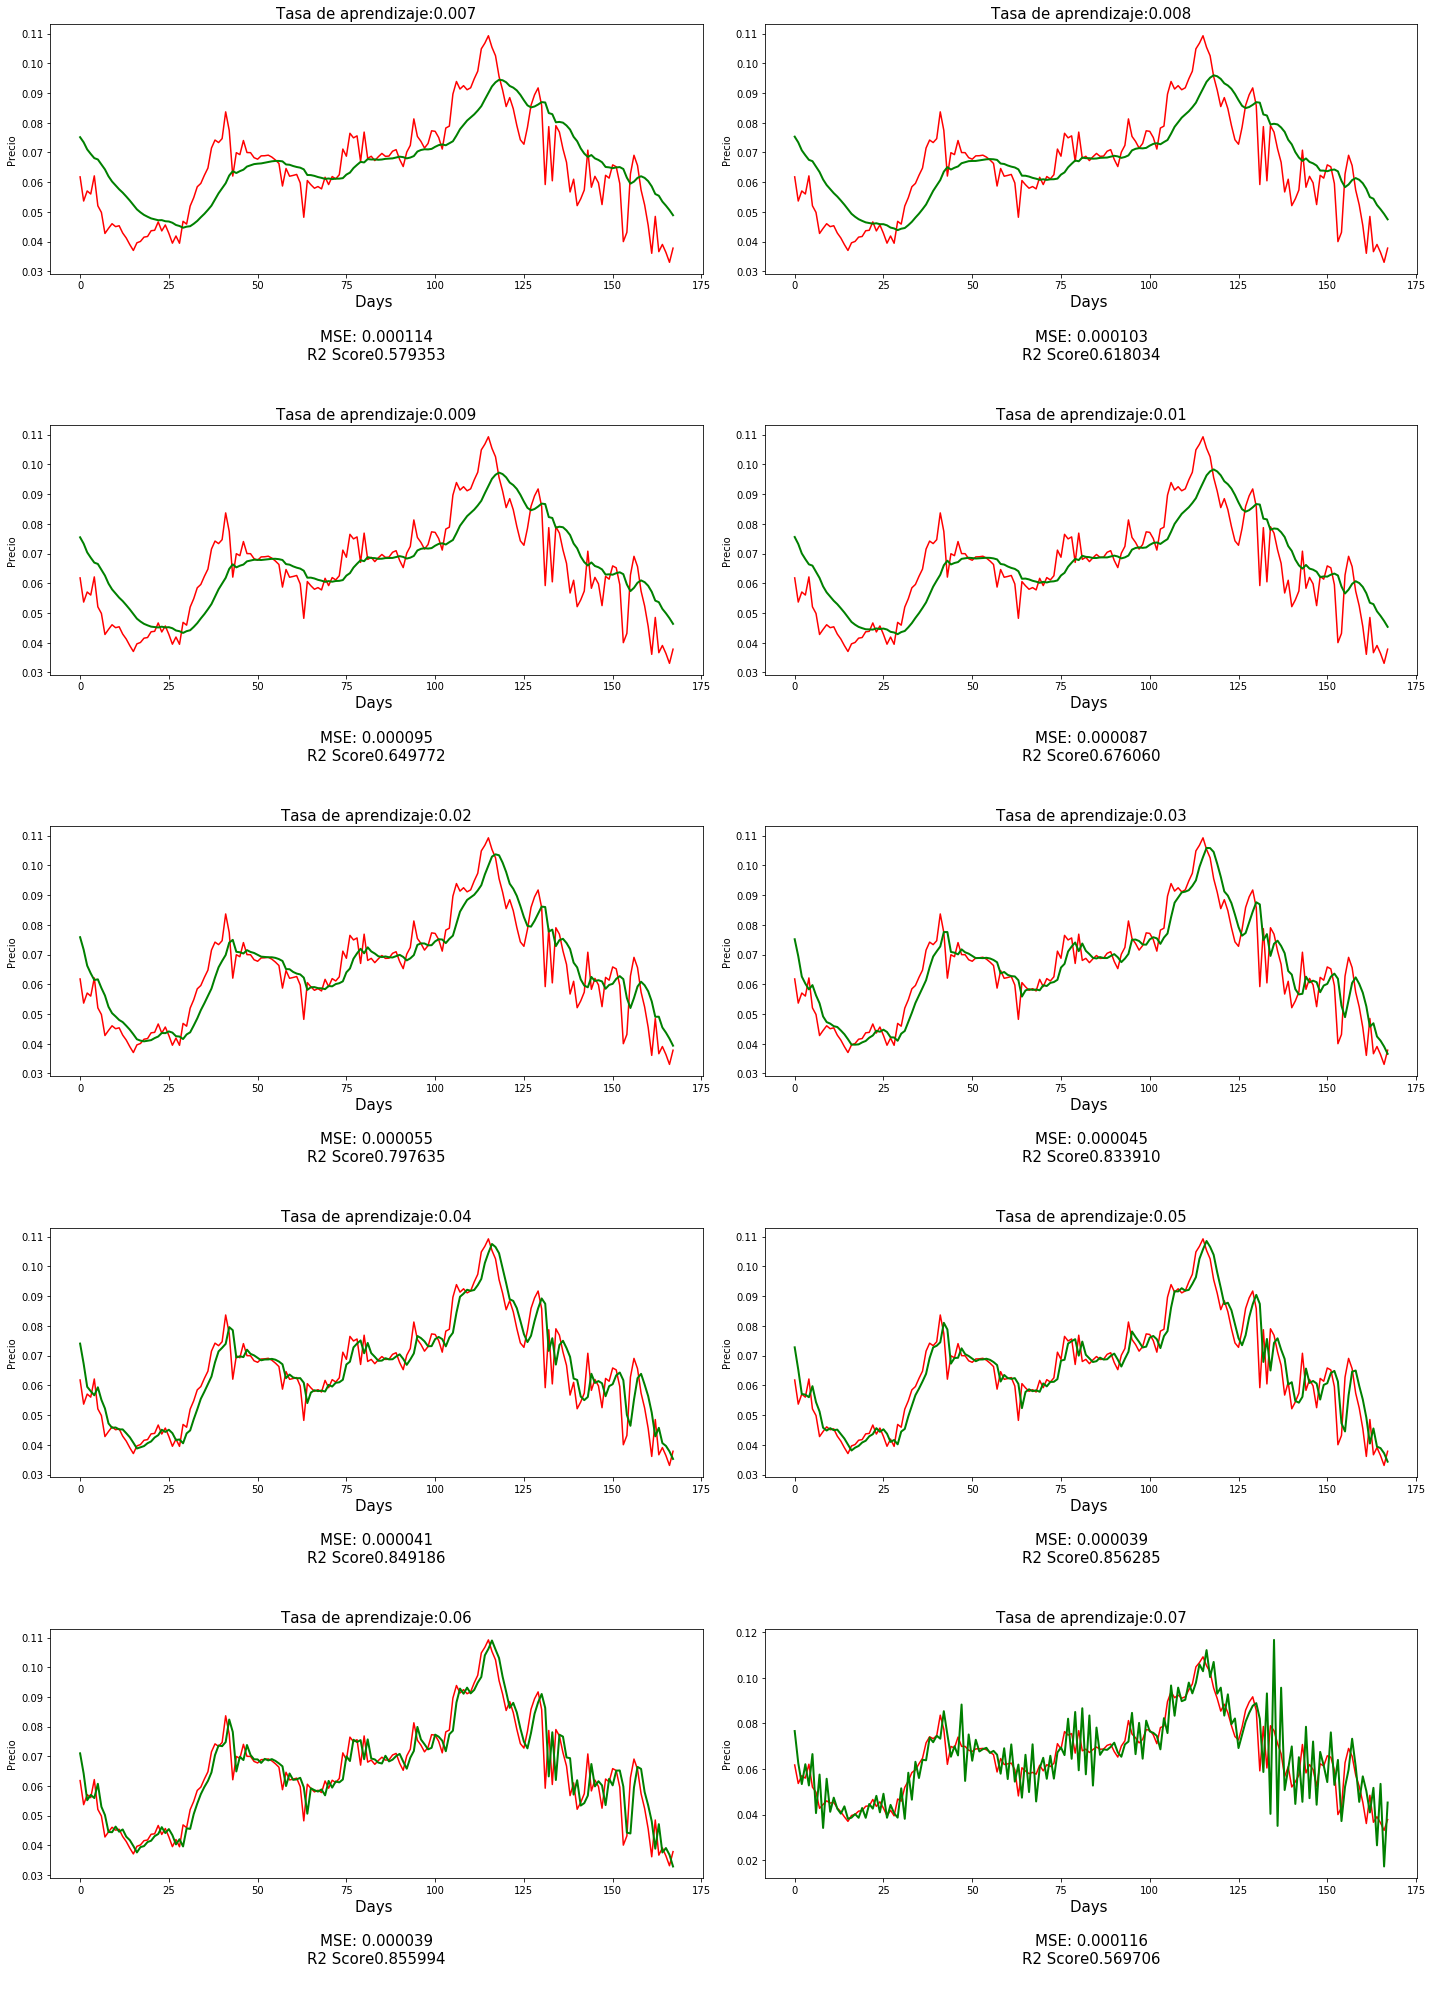

In [54]:
fig, axes = plt.subplots(nrows=5, ncols=2,figsize=(20,28))

count = 0
for fila in axes:
    
    for ax in fila:

        titulo = str("Tasa de aprendizaje:"+str(lr[count])) 

        ax.plot(resultado_lr[count][0],color = 'red',label = 'Real ')
        ax.plot(resultado_lr[count][1],color = 'green',label = 'Predicted',linewidth=2.0)

        ax.set_xlabel('Days \n \n'+                     
                      str('MSE: ' + '{:f}'.format(metrics.mean_squared_error(resultado_lr[count][0],resultado_lr[count][1])))+'\n'+
                      str('R2 Score' + '{:f}'.format(r2_score(resultado_lr[count][0],resultado_lr[count][1]))+'\n \n'),fontsize=15) 
                     
        ax.set_ylabel('Precio')
        ax.set_title(str('Tasa de aprendizaje:'+str(lr[count])),fontsize=15)

        fig    
        plt.tight_layout()

        count+=1

# Conclusión
La tasa de aprendizaje más adecuada para 7 retardos es 0.05

### Modelo sin transformaciones con los parámetros óptimos

In [59]:
def graficar_modelo(real,pred,nombre):
    """
    Función para gráficar el resultado y métricas de los modelos
    """
    figure(figsize=(12,6))
    plt.plot(real, color = 'cyan', label = 'Real')
    plt.plot(pred, color = 'orange', label = 'Predicho')
    plt.title(nombre)
    plt.xlabel('Horas/Día \n \n'+
              'R2: '+str(r2_score(real,pred))+'\n \n'
              'MSE: '+str(metrics.mean_squared_error(real, pred))
              )
    plt.ylabel('Precio')
    plt.legend()
    return plt.show()

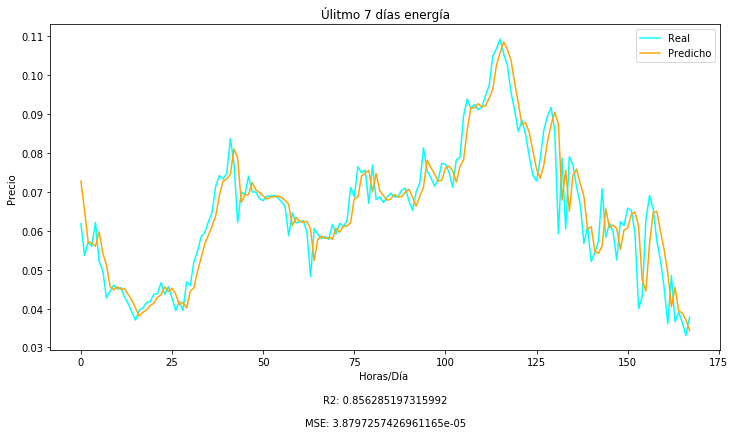

In [60]:
def adaline(L,lr,d):
    L = L

    model = Model(L)

    y_pred = np.empty(len(d))
    y_pred[:] = np.nan

    for t in range(L, len(d)):
        x = d[t-L:t]
        y_pred[t] = model(x)
        model.fit(mu=lr, x=x, y_desired=d[t])
    
    return [d[-(dias_a_predecir):],y_pred[-(dias_a_predecir):]]
    
modelo_sin_transf = adaline(6,0.05,d)

graficar_modelo(modelo_sin_transf[0],modelo_sin_transf[1],"Úlitmo 7 días energía")

## Selección de transformacion adecuada
Se define un metodo para evaluar los resultados entre las diferentes transformaciones aplicadas al modelo

In [63]:
def evaluacion(resultados,parametros):    
    metricas = []
    
    for i in range(len(resultados)): 
        real,pred = resultados[i][0],resultados[i][1]
        
        r2 = r2_score(real,pred)
        mse = metrics.mean_squared_error(real, pred)
        
        metricas.append([r2,mse])
     
    df = pd.DataFrame(metricas,parametros)
    
    return df.sort_values(by=[0],ascending=False).iloc[0]

### Transformación Raiz cuadrada

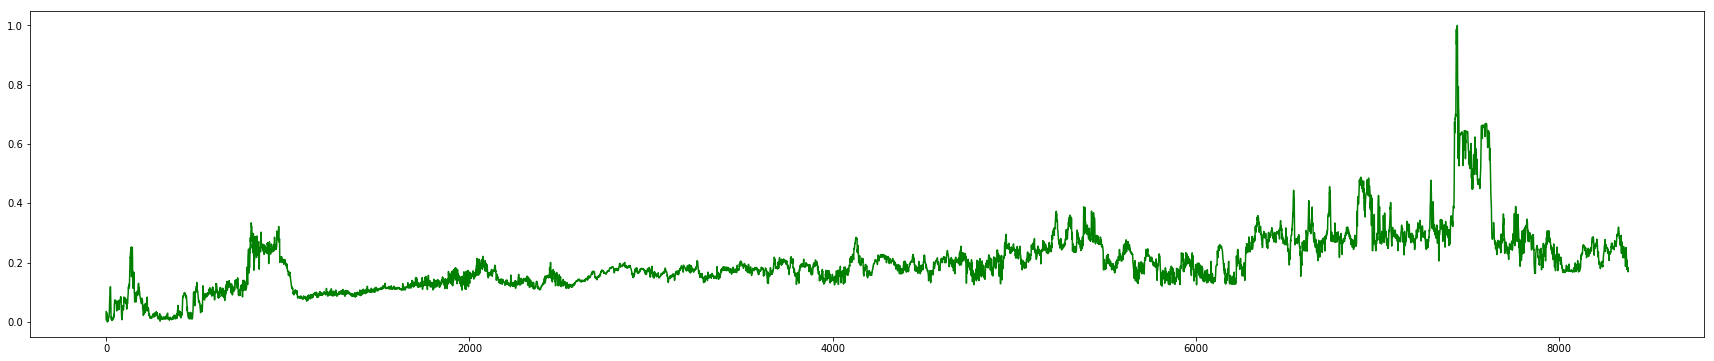

In [65]:
serie_sqrt = sc.fit_transform(serie["price"].apply(np.sqrt).values.reshape(-1,1)).reshape(-1,)
figure(figsize=(30,6))
plt.plot(serie_sqrt, '-g')

Se evalua los resultados de la calibracion de retardos para la transformacion y se define cual es el mejor parametro y con que retardo

In [66]:
resultado_retardos_sqrt = tuning_retardos(retardos,serie_sqrt)

mejor_retardo_sqrt = evaluacion(resultado_retardos_sqrt,retardos)

mejor_retardo_sqrt

0    0.849723
1    0.000163
Name: 5, dtype: float64

##### Calibración de la regresión lineal

In [67]:
## evaluo los resultados de la calibración de la LR para la transformación de la raíz cuadrada 
resultado_lr_sqrt = tuning_lr(lr,serie_sqrt)

## Obtengo el mejor parámetro
mejor_lr_sqrt = evaluacion(resultado_lr_sqrt,lr)

## Una tasa de aprendizaje de 0.04
mejor_lr_sqrt

0    0.852204
1    0.000160
Name: 0.04, dtype: float64

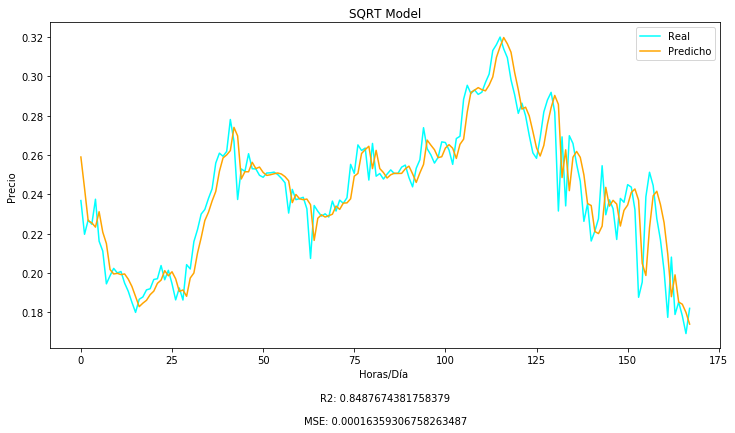

In [68]:
modelo_sqrt = adaline(5,0.04,serie_sqrt)

graficar_modelo(modelo_sqrt[0],modelo_sqrt[1],"SQRT Model")

### Transformación Raiz cúbica

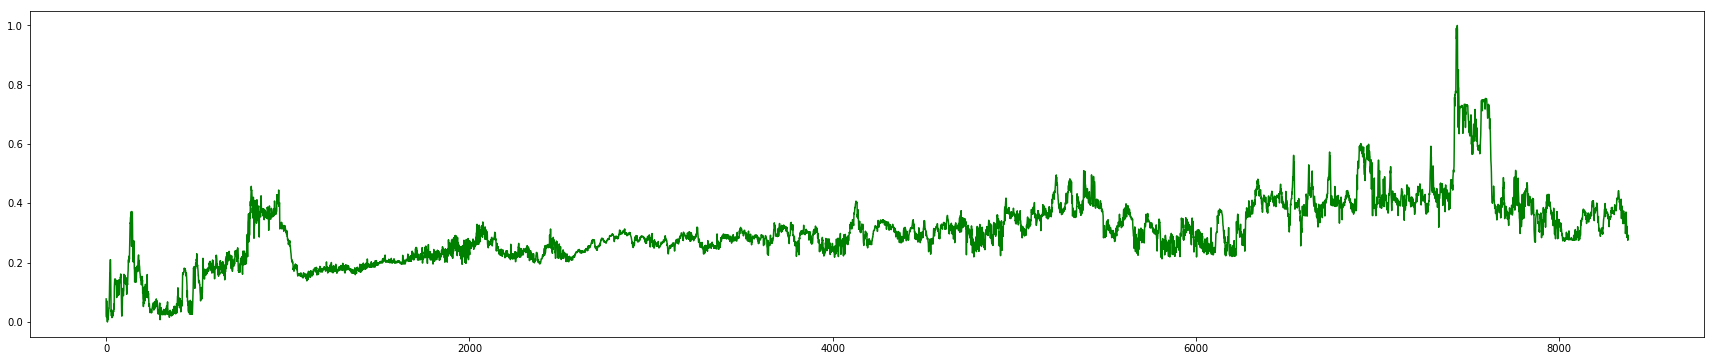

In [70]:
serie_cbrt = sc.fit_transform(np.array(serie["price"].apply(np.cbrt).values.reshape(-1,1))).reshape(-1,)

figure(figsize=(30,6))
plt.plot(serie_cbrt,'-g')

Se evalua los resultados de la calibracion de retardos para la transformacion y se define cual es el mejor parametro y con que retardo

In [71]:
resultado_retardos_cbrt = tuning_retardos(retardos,serie_cbrt)

resultado_retardos_cbrt = resultado_retardos_cbrt[0:6]

mejor_retardo_cbrt = evaluacion(resultado_retardos_cbrt,retardos[0:6])

mejor_retardo_sqrt

0    0.849723
1    0.000163
Name: 5, dtype: float64

##### Calibración de la regresión lineal

In [72]:
## evaluo los resultados de la calibración de la LR para la transformación de la raíz cúbica
resultado_lr_cbrt = tuning_lr(lr,serie_cbrt)

## Obtengo el mejor parámetro
mejor_lr_cbrt = evaluacion(resultado_lr_cbrt,lr)

## Una tasa de aprendizaje de 0.03
mejor_lr_cbrt

0    0.849775
1    0.000201
Name: 0.03, dtype: float64

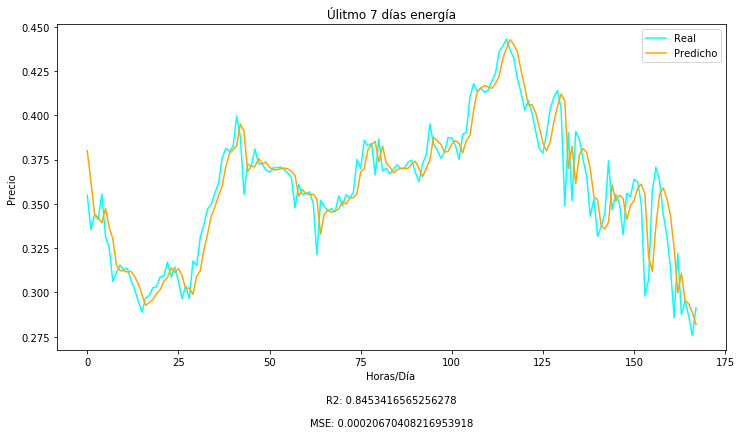

In [73]:
modelo_cbrt = adaline(5,0.03,serie_cbrt)

graficar_modelo(modelo_cbrt[0],modelo_cbrt[1],"Úlitmo 7 días energía")

### Transformacion Logaritmo Natural

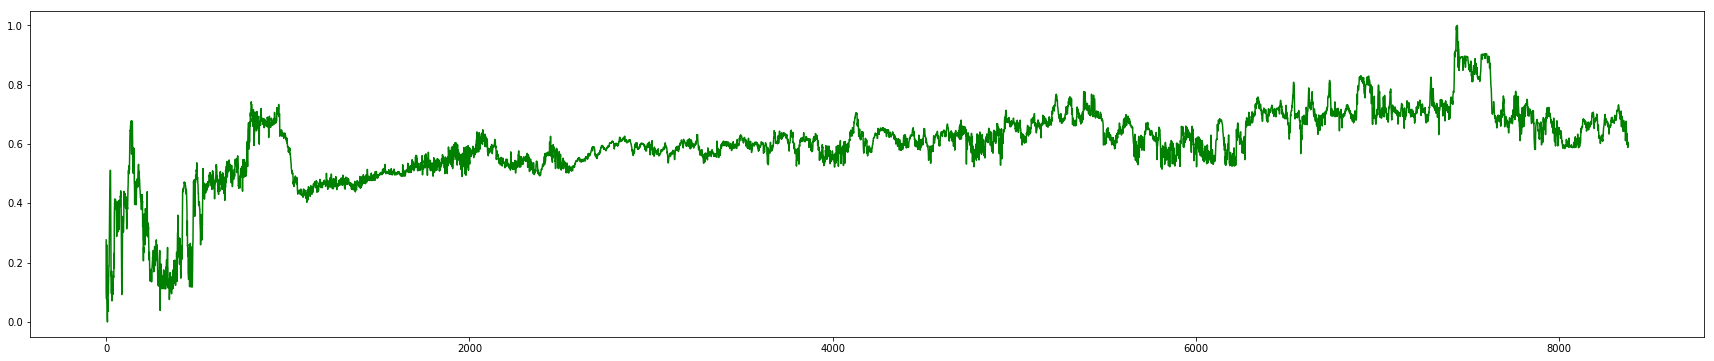

In [74]:
serie_log = sc.fit_transform(np.array(serie["price"].apply(np.log).values).reshape(-1,1)).reshape(-1,)
figure(figsize=(30,6))
plt.plot(serie_log,'-g')

Se evalua los resultados de la calibracion de retardos para la transformacion y se define cual es el mejor parametro y con que retardo

In [75]:
resultado_retardos_log = tuning_retardos(retardos,serie_log)

mejor_retardo_log = evaluacion(resultado_retardos_log[:-3],retardos[:-3])

mejor_retardo_log

0    0.847949
1    0.000151
Name: 2, dtype: float64

##### Calibración de la regresión lineal

In [76]:
## evaluo los resultados de la calibración de la lr para la transformación del logaritmo natural
resultado_lr_log = tuning_lr(lr,serie_log)

## Obtengo el mejor parámetro
mejor_lr_log = evaluacion(resultado_lr_log[:-2],lr[:-2])

## Una tasa de aprendizaje de 0.04
mejor_lr_sqrt

0    0.852204
1    0.000160
Name: 0.04, dtype: float64

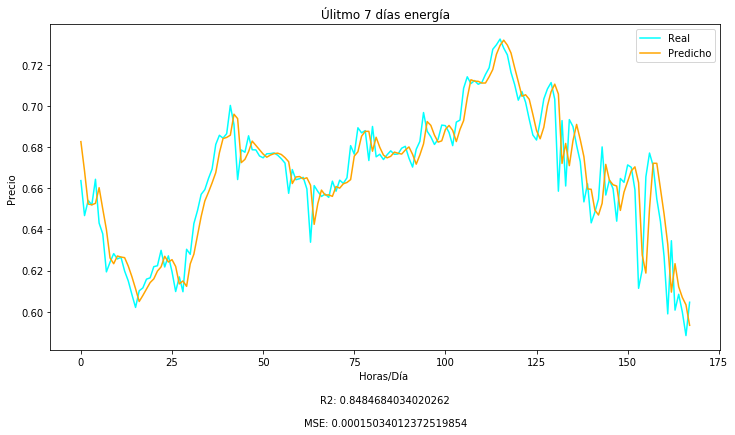

In [77]:
modelo_log = adaline(2,0.04,serie_log)

graficar_modelo(modelo_log[0],modelo_log[1],"Úlitmo 7 días energía")

## Resultados de los modelos con Adaline:
    
    Sin transformación: 
        - R2          0.8562      - MSE       3.8797e-05

    Raíz Cuadrada
        - R2          0.8497      - MSE       0.000163

    Raíz Cúbica
         - R2         0.8497      - MSE       0.000163

    Logaritmo Natural
         - R2         0.8479      - MSE       0.000151